# Module 9: Simulating Molecular Systems: Water Box with ASE

Welcome to Module 9! In the previous module, we used ASE to simulate a simple Lennard-Jones fluid. Now, we move to a more complex and ubiquitous molecular system: **liquid water**.

This notebook is configured for a **beginner-safe quick run by default** so every cell finishes in reasonable time. You can switch to a longer run after confirming the workflow works end-to-end.

## Lesson 8.1: Force Fields for Molecular Systems

**Recap:** Force fields approximate the potential energy of a system based on atomic positions. For molecules, they typically include bonded and non-bonded terms.

**Water Models:** Many specialized water models exist (e.g., TIP3P, SPC/E - rigid; TIP4P-Fx - flexible). Rigid models are computationally cheaper.

**Using Force Fields in ASE:** ASE can interface with external MD engines (OpenMM, LAMMPS) for complex force fields. For simpler models, ASE might have built-in calculators. We will use the built-in `ase.calculators.tip3p.TIP3P` calculator (a rigid model) for demonstration. For research, using ASE with OpenMM or LAMMPS is often preferred for standard biomolecular force fields.

### Importing ASE and Setting up

Import necessary modules, including the TIP3P calculator and the standard RDF function.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ASE imports - assuming ASE is installed
from ase import Atoms, units, Atom
from ase.io import read, write, Trajectory
from ase.build import molecule
from ase.io import write

# Water models
# Basic rigid model - TIP3P
from ase.calculators.tip3p import TIP3P, rOH, angleHOH

# Molecular Dynamics
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary

# Constraints
from ase.constraints import FixBondLengths # Needed for rigid models

# Geometry analysis - Radial Distribution Function (RDF)
from ase.geometry.analysis import get_rdf

print("ASE modules imported.")

# Plotting style
# plt.style.use('seaborn-v0_8-darkgrid') # Uncomment to use this style
plt.rcParams['figure.figsize'] = (6,4)

# Beginner-friendly runtime switch
FAST_MODE = True
print(f"FAST_MODE = {FAST_MODE} (set to False for larger/longer water simulations)")


ASE modules imported.
FAST_MODE = True (set to False for larger/longer water simulations)


## Lesson 8.2: Setting up the Water Box

We need a starting configuration for a box of water molecules. Ideally, use a tool like `Packmol` to generate an `xyz` or `pdb` file. We assume `water_atoms.xyz` exists.
*(A fallback generator is commented out below for basic testing).*

In [2]:
# --- Parameters ---
water_atoms_filename = "waterbox.xyz"
n_waters = 48 if FAST_MODE else 125
target_density_g_cm3 = 1.0  # ~liquid water
jitter_fraction = 0.05      # fraction of grid spacing used to jitter positions
seed = 7                 # set to an int for reproducibility

# --- Helpers ---
def random_rotation_matrix(rng):
    """Uniform random rotation (SO(3)) via QR decomposition."""
    A = rng.standard_normal((3, 3))
    Q, _ = np.linalg.qr(A)
    if np.linalg.det(Q) < 0:
        Q[:, 0] *= -1
    return Q

# --- Build a 64-water box and write to extxyz ---
def create_water_box(filename, n_waters, density_g_cm3, jitter_frac=0.10, seed=None):
    rng = np.random.default_rng(seed)

    # Single water molecule
    h2o = molecule("H2O")

    # Compute cubic box length from target density
    # mass per molecule (g) = (18.01528 g/mol) / N_A
    mass_per_molecule_g = 18.01528 / 6.02214076e23
    volume_per_molecule_cm3 = mass_per_molecule_g / density_g_cm3
    volume_per_molecule_A3 = volume_per_molecule_cm3 * 1e24
    total_volume_A3 = n_waters * volume_per_molecule_A3
    L = total_volume_A3 ** (1 / 3)  # box length in Å

    # Place molecules on a cubic grid, then jitter slightly
    ngrid = int(np.ceil(n_waters ** (1 / 3)))  # for 64 => 4
    spacing = L / ngrid
    centers = []
    for i in range(ngrid):
        for j in range(ngrid):
            for k in range(ngrid):
                centers.append(((i + 0.5) * spacing,
                                (j + 0.5) * spacing,
                                (k + 0.5) * spacing))
    centers = np.array(centers[:n_waters], dtype=float)

    # Small random jitter to avoid perfect alignment; wrap back into the box
    jitter_amp = jitter_frac * spacing
    centers += rng.uniform(-jitter_amp, jitter_amp, size=centers.shape)
    centers %= L

    # Assemble all molecules
    symbols, coords = [], []
    for c in centers:
        mol = h2o.copy()
        # center to COM, random rotate, translate to grid center
        mol.translate(-mol.get_center_of_mass())
        R = random_rotation_matrix(rng)
        mol.positions = mol.positions @ R.T
        mol.translate(c)
        symbols.extend(mol.get_chemical_symbols())
        coords.extend(mol.positions)

    water_atoms = Atoms(symbols=symbols,
                        positions=np.array(coords),
                        cell=[L, L, L],
                        pbc=True)

    # Write as Extended XYZ so cell & PBC are saved
    write(filename, water_atoms, format="extxyz")

    # Optional: quick summary
    print(f"Wrote {n_waters} waters ({len(water_atoms)} atoms) to {filename}")
    print(f"Box length: {L:.2f} Å | Volume: {water_atoms.get_volume():.2f} Å³")

    return water_atoms

# Create (overwrite) the file now
water_atoms = create_water_box(
    filename=water_atoms_filename,
    n_waters=n_waters,
    density_g_cm3=target_density_g_cm3,
    jitter_frac=jitter_fraction,
    seed=seed,
)


Wrote 48 waters (144 atoms) to waterbox.xyz
Box length: 11.28 Å | Volume: 1435.92 Å³


### Setting the Calculator and Constraints

Attach the `TIP3P` calculator and apply `FixBondLengths` constraints for the rigid water model. Finding the correct pairs for constraints might require careful handling depending on the input file format.

In [3]:
# Set the TIP3P calculator
water_atoms.calc = TIP3P()
print("TIP3P calculator attached.")

# Define constraints for rigid water
o_indices = [a.index for a in water_atoms if a.symbol == 'O']
h_indices = [a.index for a in water_atoms if a.symbol == 'H']
oh_pairs = []
hh_pairs = []

print("Attempting to find O-H and H-H pairs for constraints based on distance...")
try:
    # Find O-H pairs and intra-molecular H-H pairs
    for i in o_indices:
        # Find hydrogens close to this oxygen
        dists_to_h = water_atoms.get_distances(i, h_indices, mic=True)
        bonded_h_indices = np.array(h_indices)[dists_to_h < 1.2] # O-H bond length ~1 A

        if len(bonded_h_indices) == 2:
            # Found the two hydrogens bonded to this oxygen
            h1_idx, h2_idx = bonded_h_indices
            oh_pairs.append(tuple(sorted((i, h1_idx))))
            oh_pairs.append(tuple(sorted((i, h2_idx))))
            hh_pairs.append(tuple(sorted((h1_idx, h2_idx))))
        elif len(bonded_h_indices) != 0: # Handle cases where only 0 or 1 H is found close
                print(f"Warning: Found {len(bonded_h_indices)} H neighbors for O atom {i}. Expected 2.")

    # Remove duplicates just in case
    oh_pairs = sorted(list(set(oh_pairs)))
    hh_pairs = sorted(list(set(hh_pairs)))

    n_waters_check = len(o_indices)
    if len(oh_pairs) != 2 * n_waters_check or len(hh_pairs) != n_waters_check:
            print(f"Warning: Found {len(oh_pairs)} O-H pairs and {len(hh_pairs)} H-H pairs "
                f"for {n_waters_check} Oxygen atoms. Constraints might be incomplete.")

    if oh_pairs and hh_pairs:
            # Create FixBondLengths constraints
            constraints_oh = FixBondLengths(oh_pairs)
            constraints_hh = FixBondLengths(hh_pairs) # Target H-H distance is implicit in FixBondLengths

            # Combine constraints
            water_atoms.set_constraint([constraints_oh, constraints_hh])
            h_h_dist_target = 2 * rOH * np.sin(np.deg2rad(angleHOH) / 2.0)
            print(f"Applied FixBondLengths constraints for rigid TIP3P water.")
            print(f"(Target O-H: {rOH:.3f} A, Target H-H: {h_h_dist_target:.3f} A)")
    else:
            print("Could not set up constraints due to missing pairs.")

except Exception as e:
    print(f"Error setting up constraints: {e}")
    print("Proceeding without constraints - simulation might be unstable with rigid model!")

TIP3P calculator attached.
Attempting to find O-H and H-H pairs for constraints based on distance...
Applied FixBondLengths constraints for rigid TIP3P water.
(Target O-H: 0.957 A, Target H-H: 1.514 A)


## Lesson 8.3: Equilibration and Production Runs (NVT/NPT)

Equilibrate the system at the target temperature before the production run. We'll perform NVT equilibration.

### Assigning Initial Velocities
Assign velocities appropriate for the target simulation temperature (e.g., 300 K).

In [4]:
# Target temperature for simulation
target_temperature_K = 300.0 # Kelvin (Room temperature)

# Set initial velocities
MaxwellBoltzmannDistribution(water_atoms, temperature_K=target_temperature_K)
Stationary(water_atoms) # Remove center-of-mass motion

# Check initial temperature
initial_kinetic_energy = water_atoms.get_kinetic_energy()
initial_temperature_K = initial_kinetic_energy / (1.5 * units.kB * len(water_atoms))
print(f"Target Temperature: {target_temperature_K:.1f} K")
print(f"Initial Temperature (from KE): {initial_temperature_K:.1f} K")

Target Temperature: 300.0 K
Initial Temperature (from KE): 181.3 K


### Running NVT Equilibration and Production

Run a short equilibration followed by a longer production run using the Langevin thermostat. Save the production trajectory.

In [5]:
# Optimization for energy minimization
from ase.optimize import BFGS # Using the BFGS algorithm for minimization

# Simulation parameters
time_step_fs = 1.0 # fs (Shorter timestep often needed for water due to H motion, even if rigid)
time_step = time_step_fs * units.fs

# Equilibration phase
equilibration_time_ps = 0.02 if FAST_MODE else 1.0 # ps
equilibration_steps = int(equilibration_time_ps * 1000 * units.fs / time_step)

# Production phase
production_time_ps = 0.02 if FAST_MODE else 5.0 # ps
production_steps = int(production_time_ps * 1000 * units.fs / time_step)

log_interval = 10  # Print status less often
traj_interval = 20 if FAST_MODE else 100 # Save trajectory frame less often
traj_filename = 'water_atoms_nvt.traj'
min_log_filename = 'water_minimization.log' # Log file for minimization

print(f"Simulation time step: {time_step_fs:.1f} fs")
print(f"Equilibration Steps: {equilibration_steps} ({equilibration_time_ps} ps)")
print(f"Production Steps: {production_steps} ({production_time_ps} ps)")

# Note: The check for 'water_atoms' and calculator has been removed as requested.
# Ensure 'water_atoms' object with a calculator is defined before this point in the script.

# --- Energy Minimization ---
if FAST_MODE:
    print("Skipping BFGS minimization in FAST_MODE for quick classroom execution.")
else:
    optimizer = BFGS(water_atoms, logfile=min_log_filename)
    optimizer.run(fmax=0.1, steps=100)
    print("Energy Minimization finished.")
    print(f"Final potential energy after minimization: {water_atoms.get_potential_energy():.4f} eV")


# Set up Langevin dynamics
# Note: The friction coefficient calculation was slightly changed in the user's last input.
# Using the version from the user's last input: friction_coeff = 100 * time_step_fs / units.fs
friction_coeff = 0.01 * time_step_fs / units.fs
dyn = Langevin(water_atoms, timestep=time_step, temperature_K=target_temperature_K, friction=friction_coeff, logfile='water_nvt.log') # Log dynamics info

# Function to print progress
def print_equil_status(a=water_atoms):
    step = dyn.get_number_of_steps()
    if step % log_interval == 0:
         ekin = a.get_kinetic_energy() / len(a)
         temp = ekin / (1.5 * units.kB)
         print(f'Equil Step: {step:6d}, Temp: {temp:.1f} K')

def print_prod_status(a=water_atoms):
    step = dyn.get_number_of_steps()
    # Add offset for total steps if needed, or just track production steps
    prod_step = step - equilibration_steps
    if prod_step % log_interval == 0:
         epot = a.get_potential_energy() / len(a)
         ekin = a.get_kinetic_energy() / len(a)
         temp = ekin / (1.5 * units.kB)
         # Using the time calculation from the user's last input: (step*time_step)/(1000 * units.fs)
         print(f'Prod Step: {prod_step:6d}, Time: {(step*time_step)/(1000 * units.fs):.2f} ps, Epot/N: {epot:.4f} eV, Temp: {temp:.1f} K')


# --- Equilibration Run ---
print(f"Starting NVT Equilibration ({equilibration_steps} steps)...")
dyn.attach(print_equil_status) # Attach equilibration logger
dyn.run(equilibration_steps) # Run equilibration without try/except
print("Equilibration finished.")


# --- Production Run ---
print(f"Starting NVT Production ({production_steps} steps)...")
# Set up trajectory saving for production phase
if os.path.exists(traj_filename):
    os.remove(traj_filename) # Overwrite previous trajectory
trajectory = Trajectory(traj_filename, 'w', water_atoms)
dyn.attach(trajectory.write, interval=traj_interval)
dyn.attach(print_prod_status) # Attach production logger

dyn.run(production_steps) # Run production without try/except
print("Production run finished successfully.")

# Important: Close the trajectory file
if 'trajectory' in locals() and trajectory is not None:
    trajectory.close()
    print("Trajectory file closed.")


Simulation time step: 1.0 fs
Equilibration Steps: 20 (0.02 ps)
Production Steps: 20 (0.02 ps)
Skipping BFGS minimization in FAST_MODE for quick classroom execution.
Starting NVT Equilibration (20 steps)...
Equil Step:      0, Temp: 181.3 K
Equil Step:     10, Temp: 569.0 K
Equil Step:     20, Temp: 668.4 K
Equilibration finished.
Starting NVT Production (20 steps)...
Equil Step:     30, Temp: 629.7 K
Prod Step:     10, Time: 0.03 ps, Epot/N: -0.0503 eV, Temp: 629.7 K
Equil Step:     40, Temp: 666.0 K
Prod Step:     20, Time: 0.04 ps, Epot/N: -0.0638 eV, Temp: 666.0 K
Production run finished successfully.
Trajectory file closed.


## Lesson 8.4: Analysis of Water Properties

Analyze the production trajectory (`water_atoms_nvt.traj`). Key properties include RDFs.

### Calculating RDFs (O-O, O-H, H-H) using ASE's `get_rdf`

We will now use the standard `ase.geometry.rdf.get_rdf` function, which is generally more efficient and robust than the manual implementation. We specify the element pairs using the `elements` argument. We analyze the **final frame** for simplicity.

Read final frame for RDF analysis from: water_atoms_nvt.traj
Calculating RDFs up to rmax = 5.54 A with 60 bins using ase.geometry.rdf.get_rdf...
Calculating O-O RDF...
O-O RDF calculation complete.
Calculating O-H RDF...
O-H RDF calculation complete.
Calculating H-H RDF...
H-H RDF calculation complete.


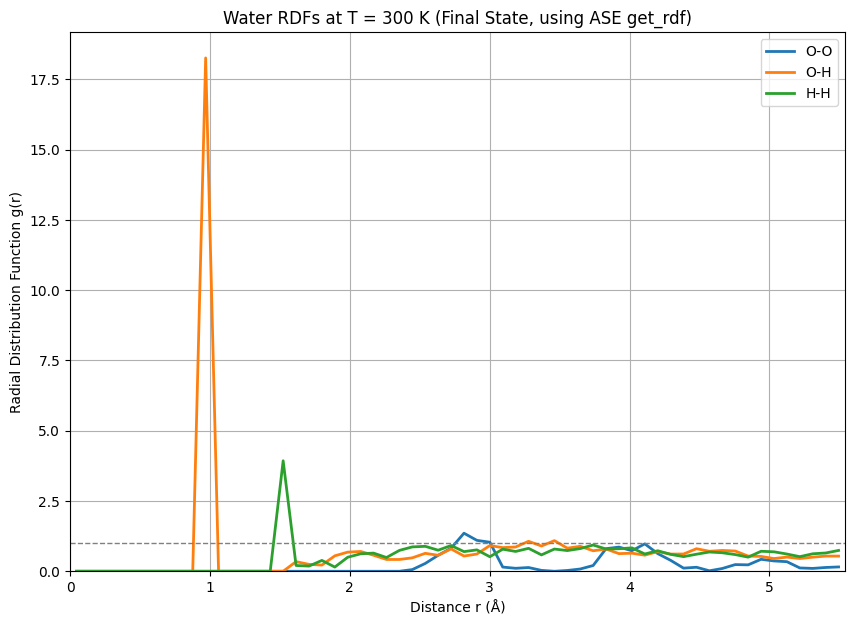


Interpretation:
- O-O RDF: First peak ~2.8 A (H-bonding distance), second peak ~4.5 A.
- O-H RDF: First peak ~1.0 A (intramolecular covalent bond), second peak ~1.8 A (H-bond).
- H-H RDF: First peak ~1.5 A (intramolecular H-H dist), broader peaks for intermolecular.


In [6]:
# --- Calculate and Plot Water RDFs using ase.geometry.rdf.get_rdf ---

# Read the final frame from the trajectory file again
final_atoms_water = None
if os.path.exists(traj_filename):
    try:
        # Read all frames, then select the last one
        traj_read = read(traj_filename, index=':')
        if traj_read:
             final_atoms_water = traj_read[-1]
             print(f"Read final frame for RDF analysis from: {traj_filename}")
        else:
             print(f"Trajectory file {traj_filename} is empty.")
    except Exception as e:
        print(f"Error reading trajectory file {traj_filename}: {e}.")

# If reading failed or file doesn't exist, try using the in-memory 'water_atoms'
if final_atoms_water is None and 'water_atoms' in locals() and water_atoms is not None:
     print("Using final state from in-memory 'water_atoms' object.")
     final_atoms_water = water_atoms


if final_atoms_water is not None and get_rdf is not None:
    # Parameters for RDF calculation
    try:
        # Use a smaller rmax for water RDFs
        rmax_rdf = np.min(final_atoms_water.cell.lengths()) / 2.0 - 0.1
        rmax_rdf = min(rmax_rdf, 8.0) # Limit to reasonable range, e.g., 8A
    except Exception:
        rmax_rdf = 8.0
    nbins_rdf = 60 if FAST_MODE else 100

    print(f"Calculating RDFs up to rmax = {rmax_rdf:.2f} A with {nbins_rdf} bins using ase.geometry.rdf.get_rdf...")


    def compute_rdf_compatible(atoms, rmax, nbins, elements):
        """Handle ASE API differences (`return_dists` vs `no_dists`)."""
        try:
            # Newer API
            rdf_vals, r_bins = get_rdf(atoms, rmax, nbins, elements=elements, return_dists=True)
            return rdf_vals, r_bins
        except TypeError:
            try:
                # Older API in many ASE releases
                rdf_vals, r_bins = get_rdf(atoms, rmax, nbins, elements=elements, no_dists=False)
                return rdf_vals, r_bins
            except TypeError:
                # Fallback if only RDF values are returned
                rdf_vals = get_rdf(atoms, rmax, nbins, elements=elements, no_dists=True)
                r_bins = np.linspace(0.0, rmax, nbins)
                return rdf_vals, r_bins

    # --- Calculate Specific RDFs ---
    rdf_OO, r_bins_OO = (None, None)
    rdf_OH, r_bins_OH = (None, None)
    rdf_HH, r_bins_HH = (None, None)

    try:
        # Calculate O-O RDF
        print("Calculating O-O RDF...")
        rdf_OO, r_bins_OO = compute_rdf_compatible(final_atoms_water, rmax_rdf, nbins_rdf, elements=(8, 8))
        print("O-O RDF calculation complete.")
    except Exception as e:
        print(f"Error calculating O-O RDF: {e}")

    try:
        # Calculate O-H RDF
        print("Calculating O-H RDF...")
        rdf_OH, r_bins_OH = compute_rdf_compatible(final_atoms_water, rmax_rdf, nbins_rdf, elements=(8, 1))
        print("O-H RDF calculation complete.")
    except Exception as e:
        print(f"Error calculating O-H RDF: {e}")

    try:
        # Calculate H-H RDF
        print("Calculating H-H RDF...")
        rdf_HH, r_bins_HH = compute_rdf_compatible(final_atoms_water, rmax_rdf, nbins_rdf, elements=(1, 1))
        print("H-H RDF calculation complete.")
    except Exception as e:
        print(f"Error calculating H-H RDF: {e}")


    # --- Plotting ---
    plt.figure(figsize=(10, 7))
    plot_successful = False
    if rdf_OO is not None and r_bins_OO is not None:
        plt.plot(r_bins_OO, rdf_OO, label='O-O', lw=2)
        plot_successful = True
    if rdf_OH is not None and r_bins_OH is not None:
        plt.plot(r_bins_OH, rdf_OH, label='O-H', lw=2)
        plot_successful = True
    if rdf_HH is not None and r_bins_HH is not None:
        plt.plot(r_bins_HH, rdf_HH, label='H-H', lw=2)
        plot_successful = True

    if plot_successful:
        plt.xlabel("Distance r (Å)")
        plt.ylabel("Radial Distribution Function g(r)")
        plt.title(f"Water RDFs at T = {target_temperature_K:.0f} K (Final State, using ASE get_rdf)")
        plt.axhline(1.0, color='grey', linestyle='--', linewidth=1)
        plt.grid(True)
        plt.xlim(0, rmax_rdf)
        plt.ylim(bottom=0)
        plt.legend()
        plt.show()

        print("\nInterpretation:")
        print("- O-O RDF: First peak ~2.8 A (H-bonding distance), second peak ~4.5 A.")
        print("- O-H RDF: First peak ~1.0 A (intramolecular covalent bond), second peak ~1.8 A (H-bond).")
        print("- H-H RDF: First peak ~1.5 A (intramolecular H-H dist), broader peaks for intermolecular.")
    else:
        print("No RDF data available to plot.")

elif get_rdf is None:
    print("Skipping RDF calculation as 'get_rdf' function was not imported.")
else:
    print("Skipping RDF calculation as no final state could be obtained.")

### Other Analyses (Conceptual)

* **Mean Squared Displacement (MSD):** Calculate $\langle |\mathbf{r}_i(t) - \mathbf{r}_i(t_0)|^2 \rangle$ averaged over all atoms $i$ and time origins $t_0$. Plot vs. time $t$. For long times, MSD $\approx 6Dt$, where $D$ is the diffusion coefficient. Requires processing the whole trajectory.
* **Hydrogen Bonding:** Define geometric criteria (e.g., O-O distance < 3.5 A, H-O...O angle < 30 deg) and count H-bonds per molecule over time. Requires iterating through trajectory frames and checking geometry.


---
End of Module 8. We have applied ASE to simulate a molecular system, liquid water:

* Discussed **molecular force fields** and common **water models** (TIP3P).
* Set up a simulation box, reading from an external file (or generating a simple one).
* Used the built-in `TIP3P` calculator and applied **constraints** for a rigid model.
* Performed **NVT equilibration and production runs** using Langevin dynamics.
* Used the standard ASE function `ase.geometry.rdf.get_rdf` to calculate **atom-type specific RDFs** (O-O, O-H, H-H) and interpreted their features.
* Conceptually discussed other analyses like **MSD** and **hydrogen bonding**.

This module highlights the steps involved in simulating molecular systems, emphasizing the importance of appropriate force fields and analysis techniques. The next module will conclude the course.